In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append("scripts")
import rr_em

In [5]:
stim = rr_em.stimulus.RandomStimulusGenerator(num_words=1000, phoneme_voc_size=len(rr_em.generator.phoneme2idx))
ds_args = dict(response_type="gaussian", epoch_window=(-0.1, 0.71))
dataset = rr_em.generator.sample_dataset(rr_em.get_parameters(), stim, **ds_args)
test_dataset = rr_em.generator.sample_dataset(dataset.params, stim, **ds_args)

In [6]:
dataset.Y_epoch[:, :, 0]

tensor([[-0.1426,  0.9744,  2.2342,  ...,  0.4871, -0.4822,  0.7101],
        [ 0.2366,  0.4955,  0.3980,  ...,  0.0229, -0.0080,  0.3313],
        [-0.6980, -0.6046,  0.9363,  ..., -0.2442, -0.2451, -1.4373],
        ...,
        [-2.3779, -1.2997, -0.8239,  ..., -0.9058, -0.0229, -0.4002],
        [ 0.9236,  0.7023, -0.6792,  ...,  0.1588,  1.2709,  1.2310],
        [-0.5862, -0.5273,  0.1842,  ...,  0.5918, -1.3755, -0.4291]])

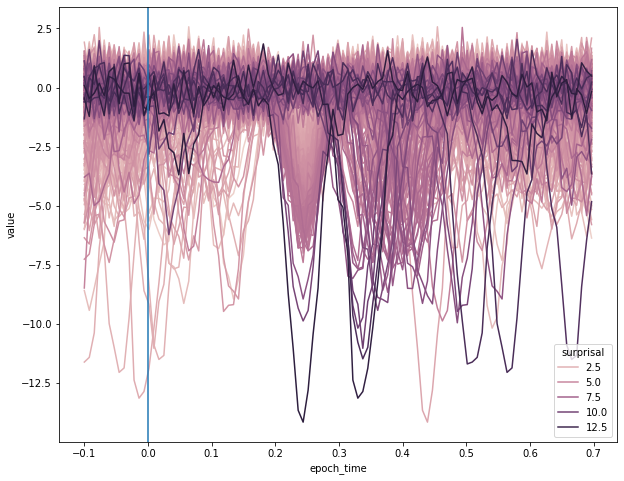

In [7]:
to_plot = pd.DataFrame(dataset.Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_epoch[:, 1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += dataset.epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)

----

In [8]:
param_grid = [rr_em.get_parameters() for _ in range(50)]

In [21]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=2, rf_estimator=1e-5)

torch.Size([67587, 2]) torch.Size([67587, 1])
Fitting 1 epochs, 2 channels


  0%|          | Sample : 0/5 [00:00<?,       ?it/s]

--- <class 'rr_em.Encoder'>


RuntimeError: No active exception to reraise

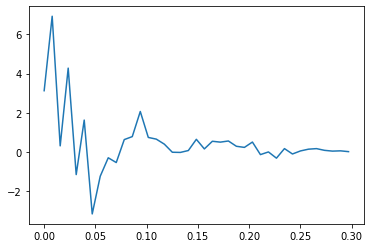

In [150]:
response_coef = encoders[-1].coef_[0, 1]
plt.plot(np.arange(response_coef.shape[0]) / dataset.sample_rate, response_coef)

<AxesSubplot:xlabel='component', ylabel='value'>

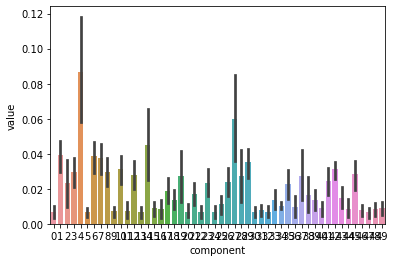

In [151]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

In [152]:
to_plot.groupby("component").value.mean().sort_values(ascending=False).head(10)

component
4     0.086393
27    0.060027
14    0.044759
1     0.039205
6     0.038600
7     0.037528
29    0.034999
42    0.031339
10    0.031323
8     0.029652
Name: value, dtype: float32

In [153]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [154]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0    0.530188
1    0.412956
2    0.618617
3    0.344546
4    0.644037
dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

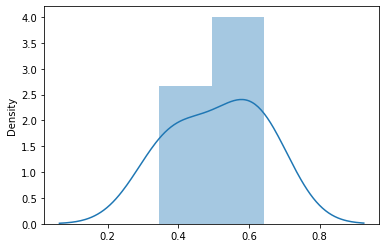

In [155]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [156]:
dataset.params.threshold

tensor(0.1807)